In [5]:
import torch
#import clip
#import clip.model
from torch.utils.data import  DataLoader

from Data import Solardataloader,Solardataloader_subset

import random
import multiprocessing

from Model.SolarCLIP import SolarCLIP_MODEL
multiprocessing.freeze_support()

import argparse

import matplotlib.pyplot as plt
import numpy as np
random.seed(40)
device = "cuda:1" if torch.cuda.is_available() else "cpu"


In [6]:
dataloader = Solardataloader_subset.SolarDataLoader(enhance_list = [['None',224,1],['None',224,1]],batch_size=4)
    # num_shuffle = 100000)

SolarModel = SolarCLIP_MODEL(
        embed_dim = 512,
        vision_width = 768,
        image_resolution_mag = 224,
        vision_layers_mag = 12,
        vision_patch_size_mag = 32,
        image_resolution_H = 224,
        vision_layers_H = 12,
        vision_patch_size_H = 32,
        transformer_token_type='class embedding'
).to(device)

# SolarModel.load_state_dict(torch.load('../../nas/ctf/SolarClip/epoch_50.pt',map_location=device),strict=False)

# SolarModel = SolarModel.eval()  

In [7]:
optimizer = torch.optim.Adam(SolarModel.parameters(), lr = 0.0001) 
epochs = 3
for epoch in range(epochs):
    for data in dataloader:
        mag_image = data[:,0,:,:,:] # [batch, channel, height, width]
        # print(mag_image.shape)
        h_image = data[:,1,:,:,:]

        mag_image = mag_image.to(device)
        h_image = h_image.to(device)

        logits_per_image, logits_per_text = SolarModel(mag_image, h_image)
        
        ground_truth = torch.arange(len(mag_image), dtype=torch.long, device=device)
        
        loss_img = torch.nn.functional.cross_entropy(logits_per_image, ground_truth)
        loss_txt = torch.nn.functional.cross_entropy(logits_per_text, ground_truth)
        loss = (loss_img + loss_txt) / 2
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch {epoch} loss: {loss.item()}')

KeyboardInterrupt: 

In [6]:
for data in dataloader:
    mag_image = data[:,0,:,:,:]
    h_image = data[0,1,0,:,:]
    print(mag_image.shape)
    print(data.shape)
    break

torch.Size([32, 1, 224, 224])
torch.Size([32, 2, 1, 224, 224])


mag: -154.58424133742008 154.58424133742008
h: -0.30862148501744974 23.481280157702784
mag: -4.341832529957083 4.341832529957083
h: -0.24852697809121047 3.1681912020469025


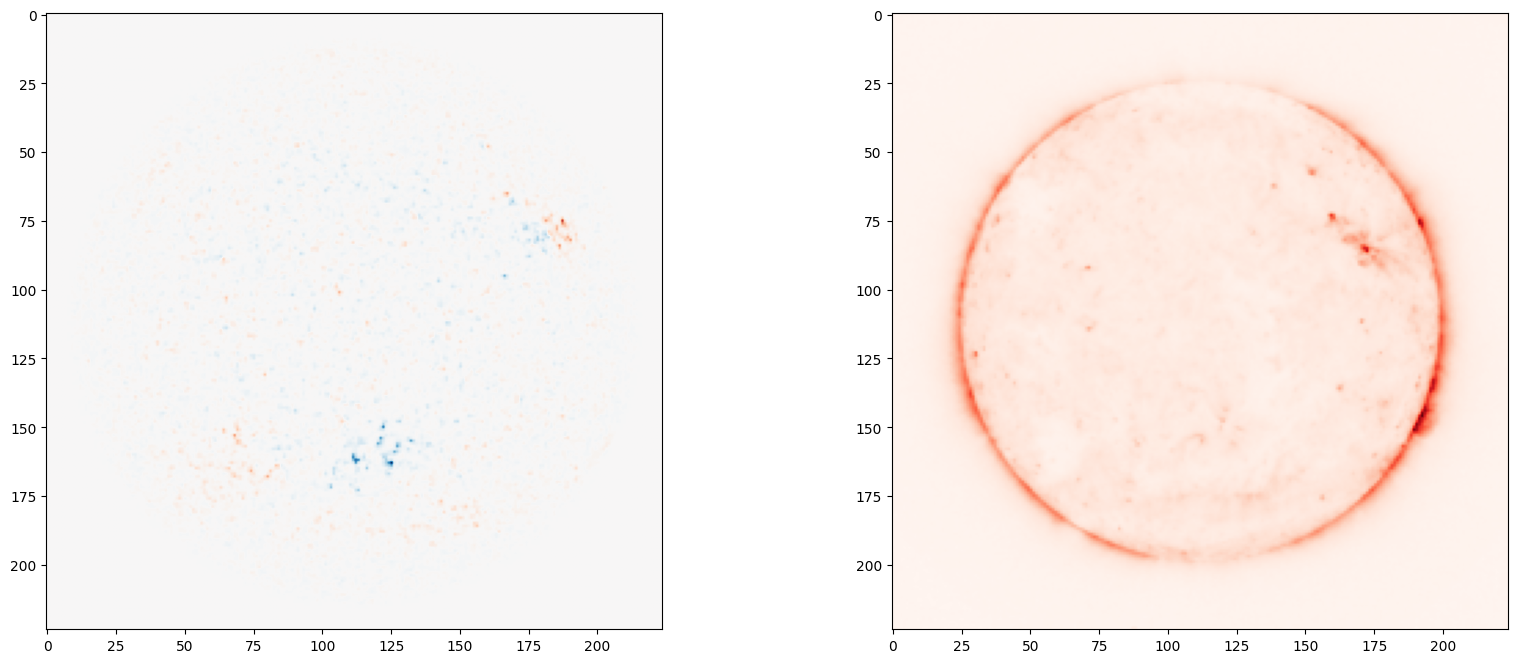

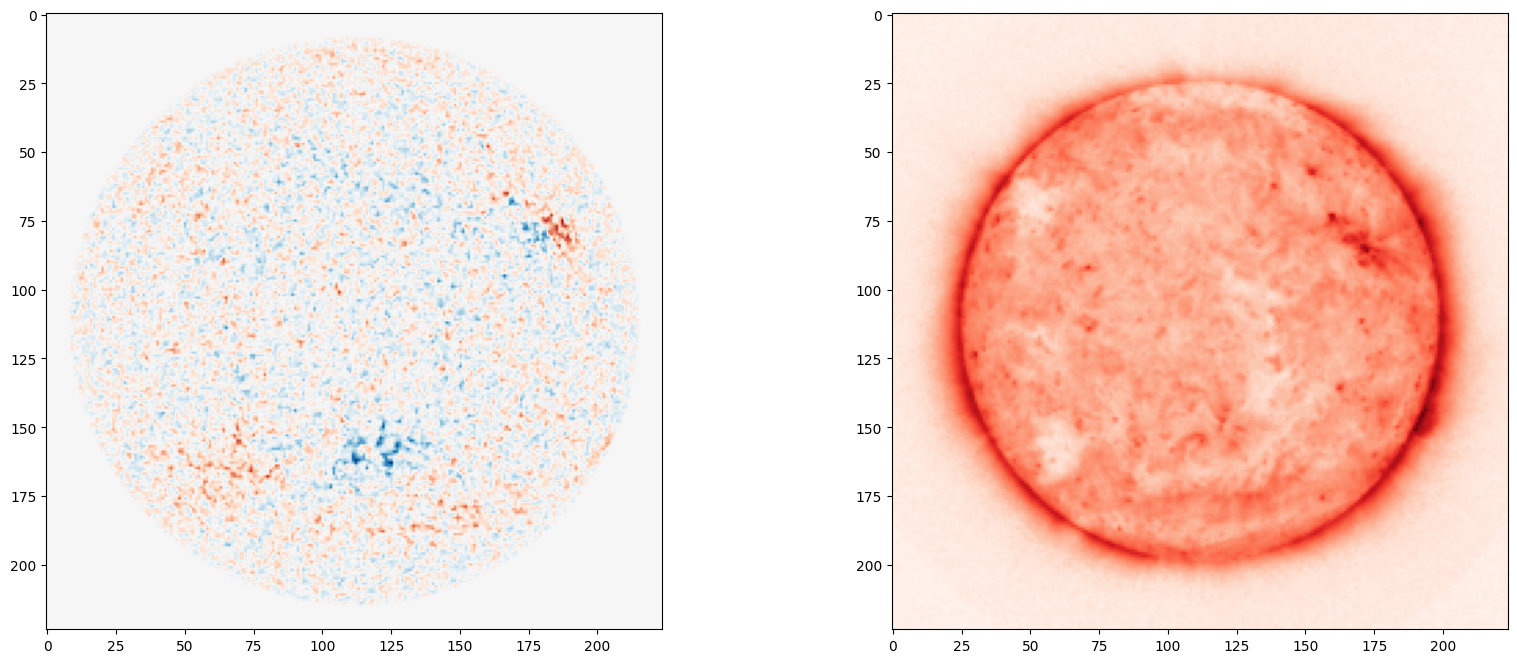

In [11]:
for data in dataloader:
    mag_image = data[0,0,0,:,:]
    h_image = data[0,1,0,:,:]
    print(mag_image.shape)
    fig,ax = plt.subplots(1, 2,figsize =(20, 8))
    h = torch.squeeze(h_image).cpu().numpy()
    mag=torch.squeeze(mag_image).cpu().numpy()
    vmin_mag = np.min(mag)
    vmax_mag = np.max(mag)
    vmax_mag = np.max([np.abs(vmin_mag),np.abs(vmax_mag)])
    vmin_h = np.min(h)
    vmax_h = np.max(h)
    ax[0].imshow(mag,cmap='RdBu_r',vmin=-vmax_mag,vmax=vmax_mag)
    ax[1].imshow(h,cmap='Reds',vmin=vmin_h,vmax=vmax_h)
    print('mag:',vmin_mag,vmax_mag)
    print('h:',vmin_h,vmax_h)
    break
for data in dataloader_log:
    mag_image = data[0,0,0,:,:]
    h_image = data[0,1,0,:,:]

    fig,ax = plt.subplots(1, 2,figsize =(20, 8))
    h = torch.squeeze(h_image).cpu().numpy()
    mag=torch.squeeze(mag_image).cpu().numpy()
    vmin_mag = np.min(mag)
    vmax_mag = np.max(mag)
    vmax_mag = np.max([np.abs(vmin_mag),np.abs(vmax_mag)])
    vmin_h = np.min(h)
    vmax_h = np.max(h)
    ax[0].imshow(mag,cmap='RdBu_r',vmin=-vmax_mag,vmax=vmax_mag)
    ax[1].imshow(h,cmap='Reds',vmin=vmin_h,vmax=vmax_h)
    print('mag:',vmin_mag,vmax_mag)
    print('h:',vmin_h,vmax_h)
    break

In [4]:
# def transfer_log1p(input_array:np.ndarray):
#     return np.sign(input_array)*np.log1p(np.abs(input_array))
def plot_matrix_with_images(matrix, row_images, col_images, save_path=None):
    num_rows, num_cols = matrix.shape
    
    fig, ax = plt.subplots(num_rows+1, num_cols+1, figsize=(num_cols+1, num_rows+1))

    # Plot the matrix
    for i in range(num_rows):
        for j in range(num_cols):
            ax[i+1, j+1].imshow(np.full((100, 100),matrix[i, j]), cmap='RdBu_r', vmin=-1, vmax=1)
            ax[i+1, j+1].text(0.5,0.5,str(matrix[i,j]),fontsize=6,ha='center',va='center')
            ax[i+1, j+1].axis('off')

    # Plot row images
    col_images = transfer_log1p(col_images)
    row_images = transfer_log1p(row_images)

    vmax_h = np.max(col_images)
    vmin_h = 0
    vmax_m = np.max(row_images)
    vmin_m = np.min(row_images)
    print(vmax_h,vmin_h,vmax_m,vmin_m)
    vmax_m = np.max((np.abs(vmax_m),np.abs(vmin_m)))
    vmin_m = -vmax_m

    for i in range(num_rows):
        ax[i+1, 0].imshow(row_images[i], cmap='RdBu_r', vmin=vmin_m, vmax=vmax_m)
        ax[i+1, 0].axis('off')

    # Plot column images
    for j in range(num_cols):
        ax[0, j+1].imshow(col_images[j], cmap='Reds', vmin=vmin_h, vmax=vmax_h)
        ax[0, j+1].axis('off')

    # Turn off the top-left empty subplot
    ax[0, 0].axis('off')

    if save_path:
        plt.savefig(save_path)
    plt.show()
    

print('device:',device)

with torch.no_grad():
    for mag_image, h_image in dataloader:
        
        mag_image = mag_image.to(device)
        
        h_image = h_image.to(device)

        logits_per_image, logits_per_text = SolarModel(mag_image, h_image)
        

        # Move tensors to CPU and convert to numpy
        mag_image_np = mag_image.cpu().numpy()
        h_image_np = h_image.cpu().numpy()
        logits_per_image_np = logits_per_image.cpu().numpy()
        print(logits_per_image_np)
        # Assume mag_image and h_image are 4D tensors with shape (batch_size, channels, height, width)
        # Take the first channel for grayscale display
        mag_image_np = mag_image_np[:, 0, :, :]
        h_image_np = h_image_np[:, 0, :, :]

        # Plot the matrix with images
        plot_matrix_with_images(logits_per_image_np, mag_image_np, h_image_np)
        break
    for mag_image, h_image in dataloader_log:
        
        mag_image = mag_image.to(device)
        
        h_image = h_image.to(device)

        logits_per_image, logits_per_text = SolarModel(mag_image, h_image)
        

        # Move tensors to CPU and convert to numpy
        mag_image_np = mag_image.cpu().numpy()
        h_image_np = h_image.cpu().numpy()
        logits_per_image_np = logits_per_image.cpu().numpy()
        print(logits_per_image_np)
        # Assume mag_image and h_image are 4D tensors with shape (batch_size, channels, height, width)
        # Take the first channel for grayscale display
        mag_image_np = mag_image_np[:, 0, :, :]
        h_image_np = h_image_np[:, 0, :, :]

        # Plot the matrix with images
        plot_matrix_with_images(logits_per_image_np, mag_image_np, h_image_np)
        break


#torch.save(RSModel.state_dict(), './weight/rsclip_model.pth')



device: cuda:1


ValueError: too many values to unpack (expected 2)

In [ ]:
# --modal_list ['magnet','0094']
# --enhance_list [['None',224,1],['None',224,1]]
# --token_type "class embedding"
dataloader_none = Solardataloader.SolarDataLoader(enhance_list = [['None',224,1],['None',224,1]])
    # num_shuffle = 100000)
SolarModel_class_none = SolarCLIP_MODEL(
        embed_dim = 512,
        vision_width = 768,
        image_resolution_mag = 224,
        vision_layers_mag = 12,
        vision_patch_size_mag = 32,
        image_resolution_H = 224,
        vision_layers_H = 12,
        vision_patch_size_H = 32,
        transformer_token_type='class embedding'
).to(device)
SolarModel_class_none.load_state_dict(torch.load('./pt/classembedding/none/epoch_50.pt',map_location=device),strict=False)
SolarModel_class_none = SolarModel.eval()  

SolarModel_all_none = SolarCLIP_MODEL(
        embed_dim = 512,
        vision_width = 768,
        image_resolution_mag = 224,
        vision_layers_mag = 12,
        vision_patch_size_mag = 32,
        image_resolution_H = 224,
        vision_layers_H = 12,
        vision_patch_size_H = 32,
        transformer_token_type='all embedding'
).to(device)
SolarModel_all_none.load_state_dict(torch.load('./pt/allembedding/none/epoch_50.pt',map_location=device),strict=False)
SolarModel_all_none = SolarModel_all_none.eval()  

with torch.no_grad():
        for data in dataloader_none:
                mag_image = data[:,0,0,:,:]
                h_image = data[:,1,0,:,:]
                


In [ ]:
# --modal_list ['magnet','0094']
# --enhance_list [['None',224,1],['None',224,1]]
# --token_type "class embedding"
dataloader_log1p = Solardataloader.SolarDataLoader(enhance_list = [['None',224,1],['None',224,1]])
    # num_shuffle = 100000)
SolarModel_class_log1p = SolarCLIP_MODEL(
        embed_dim = 512,
        vision_width = 768,
        image_resolution_mag = 224,
        vision_layers_mag = 12,
        vision_patch_size_mag = 32,
        image_resolution_H = 224,
        vision_layers_H = 12,
        vision_patch_size_H = 32,
        transformer_token_type='class embedding'
).to(device)
SolarModel_class_log1p.load_state_dict(torch.load('./pt/classembedding/log1p/epoch_50.pt',map_location=device),strict=False)
SolarModel_class_log1p = SolarModel_class_log1p.eval()  

SolarModel_all_log1p = SolarCLIP_MODEL(
        embed_dim = 512,
        vision_width = 768,
        image_resolution_mag = 224,
        vision_layers_mag = 12,
        vision_patch_size_mag = 32,
        image_resolution_H = 224,
        vision_layers_H = 12,
        vision_patch_size_H = 32,
        transformer_token_type='all embedding'
).to(device)

SolarModel_all_log1p.load_state_dict(torch.load('./pt/allembedding/log1p/epoch_50.pt',map_location=device),strict=False)
SolarModel_all_log1p = SolarModel_all_log1p.eval()



In [ ]:
# --modal_list ['magnet','0094']
# --enhance_list [['log1p',224,1],['log1p',224,1]]
# --token_type "all embedding"

In [ ]:
# --modal_list ['magnet','0094']
# --enhance_list [['None',224,1],['None',224,1]]
# --token_type "class embedding"

In [ ]:
# --modal_list ['magnet','0094']
# --enhance_list [['log1p',224,1],['log1p',224,1]]
# --token_type "all embedding"